In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import debvader
from debvader import model
from debvader.debvader import load_deblender, deblend

Load 10 DC2 images centred on galaxy. They have been generated using the code in https://github.com/BastienArcelin/dc2_img_generation

In [2]:
path_folder = os.path.dirname(os.path.abspath("__file__"))
images = np.load(path_folder+'/../data/dc2_imgs/imgs_dc2.npy', mmap_mode = 'c')

Visualize some of the images

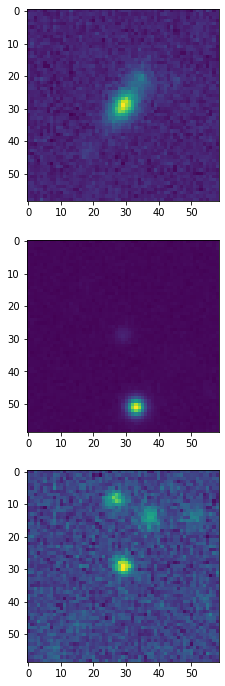

In [3]:
fig, axes = plt.subplots(3,1, figsize = (4, 12))
for i in range (3):
    axes[i].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)

Now we can load the deblender

In [4]:
# First, define the parameters of the neural network, for this version of debvader, they are as follow:
nb_of_bands = 6
input_shape = (59, 59, nb_of_bands)
latent_dim = 32
filters = [32,64,128,256]
kernels = [3,3,3,3]

# We will load the weights of the network trained on DC2 images
survey = "dc2"

In [5]:
# Load the network using the load_deblender function
net = load_deblender(survey, input_shape, latent_dim, filters, kernels)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
in cropping


In [6]:
# We can visualize the network
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 59, 59, 6)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 59, 59, 6)         24        
_________________________________________________________________
conv2d (Conv2D)              (None, 59, 59, 32)        1760      
_________________________________________________________________
p_re_lu (PReLU)              (None, 59, 59, 32)        111392    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 30, 30, 32)        28800     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496 

We now have everything to do the deblending. Let's use our network to deblend DC2 images

In [7]:
output_images = deblend(net, images)

Let's visualize the images outputed by debvader

In [8]:
output_images.shape

(10, 59, 59, 6)

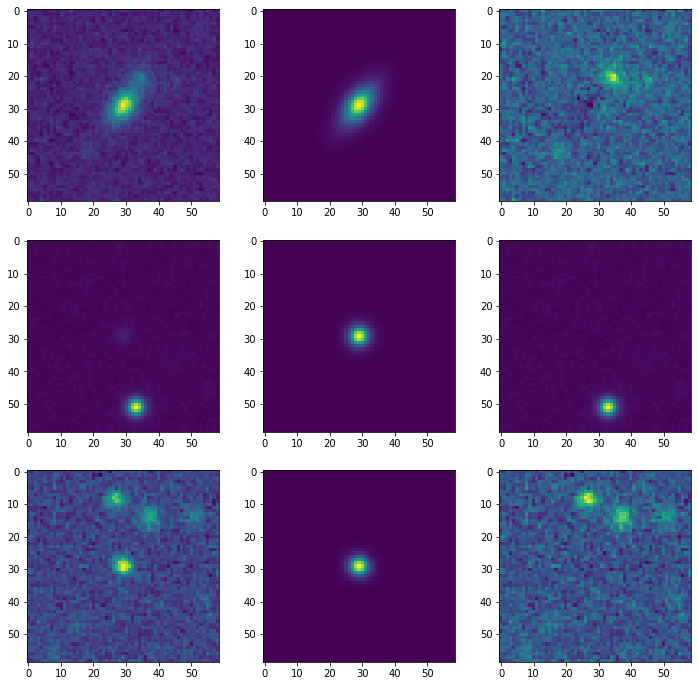

In [9]:
fig, axes = plt.subplots(3,3, figsize = (12, 12))
for i in range (3):
    axes[i,0].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)
    axes[i,1].imshow(output_images[i,:,:,2]) # We plot only r-band here, but the output images are multi-bands (ugrizy)
    axes[i,2].imshow(images[i,:,:,2]-output_images[i,:,:,2])